In [1]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")
from sklearn.linear_model import ElasticNet
from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

/Users/otomoryosuke/opt/anaconda3/envs/Python37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/otomoryosuke/opt/anaconda3/envs/Python37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
train = pd.read_csv('output.csv')
train.head()

/Users/otomoryosuke/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,...,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,1009866,中古マンション等,NaN,1101,北海道,札幌市中央区,南２６条西,電車事業所前,10,３ＬＤＫ,...,NaN,NaN,NaN,準住居地域,60.0,200.0,2013年第１四半期,未改装,NaN,7.079181
1,1009621,中古マンション等,NaN,1101,北海道,札幌市中央区,宮の森３条,西２８丁目,9,３ＬＤＫ,...,NaN,NaN,NaN,第１種中高層住居専用地域,60.0,200.0,2017年第１四半期,未改装,NaN,6.963788
2,1002994,中古マンション等,NaN,1101,北海道,札幌市中央区,北７条西,西２８丁目,6,４ＬＤＫ,...,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2011年第２四半期,未改装,NaN,7.230449
3,1000722,中古マンション等,NaN,1101,北海道,札幌市中央区,北１条西,西１１丁目,4,２ＬＤＫ,...,NaN,NaN,NaN,商業地域,80.0,600.0,2016年第１四半期,改装済,NaN,7.230449
4,1001770,中古マンション等,NaN,1101,北海道,札幌市中央区,北３条東,バスセンター前,6,３ＬＤＫ,...,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2019年第３四半期,NaN,NaN,7.602060


In [3]:
test = pd.read_csv('./data/test.csv')
test.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,...,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
0,1000000,中古マンション等,NaN,1101,北海道,札幌市中央区,旭ケ丘,円山公園,25,４ＬＤＫ,...,住宅,NaN,NaN,NaN,第１種低層住居専用地域,40.0,80.0,2021年第１四半期,未改装,NaN
1,1000001,中古マンション等,NaN,1101,北海道,札幌市中央区,旭ケ丘,円山公園,20,４ＬＤＫ,...,住宅,NaN,NaN,NaN,近隣商業地域,80.0,200.0,2021年第１四半期,未改装,NaN
2,1000062,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１１丁目,3,２ＬＤＫ,...,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2021年第１四半期,未改装,NaN
3,1000114,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,2,１ＬＤＫ,...,住宅,NaN,NaN,NaN,商業地域,80.0,400.0,2021年第１四半期,未改装,NaN
4,1000116,中古マンション等,NaN,1101,北海道,札幌市中央区,大通西,西１８丁目,4,２ＬＤＫ,...,住宅,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2021年第１四半期,未改装,NaN


In [6]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

df = pd.concat([train, test])
rm_cols += ['市区町村コード']
for i, v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [7]:
df.shape

(700543, 28)

In [8]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

In [9]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [10]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [11]:
test[TARGET] = np.nan
train.drop(rm_cols, axis=1, inplace=True)
test.drop(columns=rm_cols, axis=1, inplace=True)


In [12]:
df = pd.concat([train, test])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [13]:
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [14]:
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [15]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

In [16]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

In [18]:
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [19]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,0,-1,-1,-1,-1
1,1,1,1,1,1,0,0,-1,0,0,-1


In [20]:
le_df['今後の利用目的'].value_counts()

-1    365162
 0    311378
 2     19023
 1      3723
 3      1257
Name: 今後の利用目的, dtype: int64

In [21]:
df['今後の利用目的'].value_counts()

住宅     311378
その他     19023
事務所      3723
店舗       1257
Name: 今後の利用目的, dtype: int64

In [22]:
num_feature = [x for x in df.columns if df[x].dtype != 'object']
df[num_feature].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700543 entries, 0 to 700542
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            700543 non-null  int64  
 1   最寄駅：距離（分）     677413 non-null  float64
 2   面積（㎡）         700543 non-null  int64  
 3   建築年           680241 non-null  float64
 4   建ぺい率（％）       676793 non-null  float64
 5   容積率（％）        676793 non-null  float64
 6   取引価格（総額）_log  677392 non-null  float64
 7   取引時点_enc      700543 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 42.8 MB


In [23]:
cat_feature = [x for x in df.columns if df[x].dtype == 'object']
df[cat_feature]

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,神奈川県,横浜市南区,真金町,阪東橋,１Ｋ,ＳＲＣ,住宅,NaN,NaN,NaN,NaN
1,東京都,中野区,中央,新中野,１ＬＤＫ,ＳＲＣ,住宅,NaN,近隣商業地域,未改装,NaN
2,京都府,京都市伏見区,桃山町丹下,墨染,３ＬＤＫ,ＲＣ,住宅,NaN,第１種住居地域,未改装,NaN
3,東京都,世田谷区,深沢,都立大学,３ＬＤＫ,ＲＣ,住宅,NaN,第１種中高層住居専用地域,未改装,NaN
4,埼玉県,さいたま市緑区,原山,浦和,２ＬＤＫ,NaN,住宅,NaN,NaN,改装済,NaN
...,...,...,...,...,...,...,...,...,...,...,...
700538,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),３ＬＤＫ,ＲＣ,住宅,住宅,第１種住居地域,未改装,NaN
700539,東京都,新宿区,中落合,落合南長崎,１Ｋ,ＲＣ,NaN,住宅,近隣商業地域,未改装,NaN
700540,東京都,新宿区,中落合,落合南長崎,１Ｋ,ＲＣ,住宅,住宅,近隣商業地域,改装済,NaN
700541,愛知県,名古屋市千種区,末盛通,覚王山,１ＬＤＫ,ＲＣ,住宅,住宅,商業地域,NaN,NaN


In [26]:
feat_df = pd.concat([df[num_feature], le_df], axis=1)

In [27]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,14198339,NaN,15,1992.0,NaN,NaN,6.698970,0,0,0,0,0,0,0,0,-1,-1,-1,-1
1,13318874,NaN,40,1999.0,80.0,400.0,7.380211,0,1,1,1,1,1,0,0,-1,0,0,-1
2,26081806,4.0,60,1994.0,60.0,200.0,7.176091,0,2,2,2,2,2,1,0,-1,1,0,-1
3,13302280,NaN,85,2004.0,60.0,200.0,7.832509,0,1,3,3,3,2,1,0,-1,2,0,-1
4,11089836,NaN,50,1990.0,NaN,NaN,6.977724,0,3,4,4,4,3,-1,0,-1,-1,1,-1


In [28]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 19) (24899, 19) (23151, 19)


In [29]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [30]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [31]:
from sklearn.preprocessing import StandardScaler
train_x= train_x.fillna(train_x.mean())

In [32]:
val_x = val_x.fillna(train_x.mean())

In [33]:
test_x = test_x.fillna(train_x.mean())

In [36]:
# sc = StandardScaler()
# sc.fit(train_x)

# X_train = pd.DataFrame(sc.transform(train_x), columns=train_x.columns)
# X_val = pd.DataFrame(sc.transform(val_x), columns=val_x.columns)
# X_test = pd.DataFrame(sc.transform(test_x), columns=test_x.columns)

<AxesSubplot:>

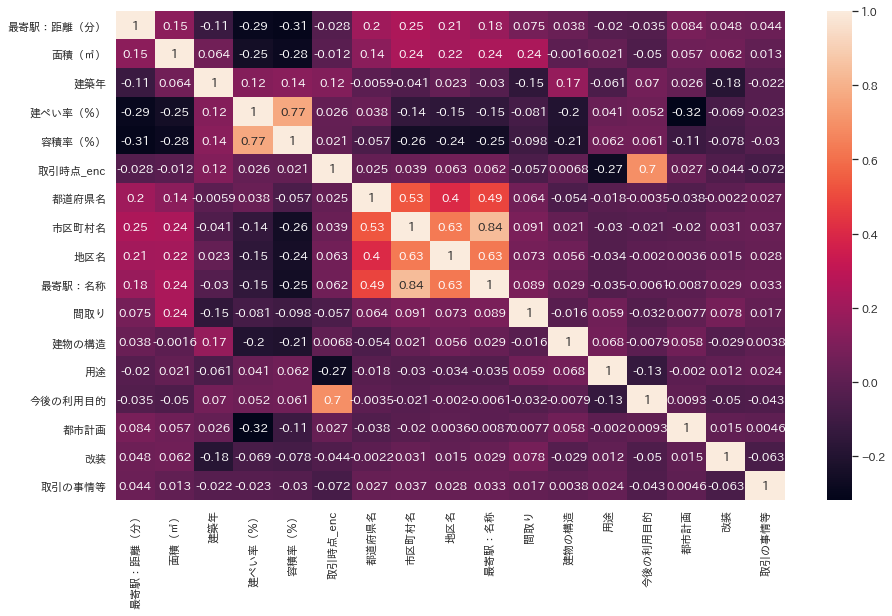

In [38]:
fig = plt.figure(figsize=(15,9))
sns.heatmap(train_x.corr(), annot=True)

In [47]:
lasso = ElasticNet(alpha=0.01,
                   l1_ratio=1.0,
                   random_state=0
                        )
lasso.fit(train_x, train_y)
y_val = lasso.predict(val_x)

In [48]:
from sklearn.metrics import mean_absolute_error as mae
mae(val_y, y_val)

0.1649832116212239

In [49]:
lasso.coef_

array([-3.72584644e-03,  6.13568759e-03,  1.47115536e-02, -2.46158372e-03,
        2.84489780e-04,  1.08809888e-03, -8.25346349e-03, -8.06462047e-05,
       -1.03383102e-05, -5.63674277e-05, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  2.42728311e-02,
       -0.00000000e+00])

In [51]:
coef_df = pd.DataFrame({'columns': train_x.columns, 'value': lasso.coef_})
coef_df

,columns,value
0,最寄駅：距離（分）,-0.003726
1,面積（㎡）,0.006136
2,建築年,0.014712
3,建ぺい率（％）,-0.002462
4,容積率（％）,0.000284
5,取引時点_enc,0.001088
6,都道府県名,-0.008253
7,市区町村名,-0.000081
8,地区名,-0.000010
9,最寄駅：名称,-0.000056


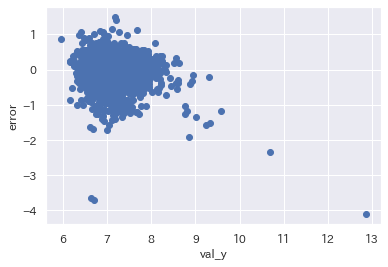

In [69]:
plt.scatter(y_val, val_y - y_val)
plt.xlabel('val_y')
plt.ylabel('error')
plt.show()

# ransacで学習したときの残差プロット
# 外れ値に対する予測が精度が下がっている

In [51]:
error = val_y - y_val

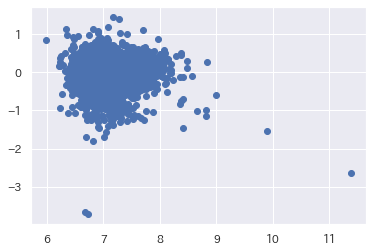

In [52]:
plt.scatter(x=y_val, y=error)

# 重回帰の残渣プロット

残差はおおむね等分散性が担保されている

外れ値の予測の乖離が大きくなっている

実データより取引額を大きく見積もることが多い

valid(重回帰）:0.1644　-> valid（ransac):0.1627 

RANSACで正常値のみ学習させてみる

In [71]:
test_pred = ransac.predict(test_x)

In [116]:
test_df[TARGET] = test_pred

/Users/otomoryosuke/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


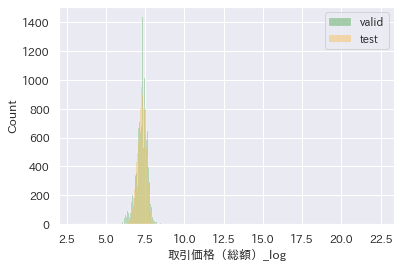

In [72]:
sns.histplot(val_y, color='green', alpha=0.3, label='valid')
sns.histplot(test_pred, color='orange', alpha=0.3, label='test')
plt.legend()